In [2]:
import pickle
import sys
import warnings

import numpy as np
import pandas as pd
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.ensemble import RandomForestClassifier

sys.path.append('../src/flare_classifier')
import mlprocessing as mlp


# 1. Perform preprocessing

read data
negative_class_shape (1000000, 3)
positive_class_shape (620543, 3)


Interpolate progress:   0%|          | 0/1241086 [00:00<?, ?it/s]

Interpolate data


Interpolate progress: 100%|██████████| 1241086/1241086 [07:21<00:00, 2810.69it/s]


scale data
mini rocket transform execute...
End mini rocket transform
PCA started...
PCA n_components=49 for 90% of the variance in the train data
PCA end
Create validation dataset
Interpolate data


Interpolate progress: 100%|██████████| 1099/1099 [00:00<00:00, 3350.59it/s]


Validation balance classes: class
0    1000
1      99
dtype: int64
List of result features (82)  ['PCA_1', 'PCA_2', 'PCA_3', 'PCA_4', 'PCA_5', 'PCA_6', 'PCA_7', 'PCA_8', 'PCA_9', 'PCA_10', 'PCA_11', 'PCA_12', 'PCA_13', 'PCA_14', 'PCA_15', 'PCA_16', 'PCA_17', 'PCA_18', 'PCA_19', 'PCA_20', 'PCA_21', 'PCA_22', 'PCA_23', 'PCA_24', 'PCA_25', 'PCA_26', 'PCA_27', 'PCA_28', 'PCA_29', 'PCA_30', 'PCA_31', 'PCA_32', 'PCA_33', 'PCA_34', 'PCA_35', 'PCA_36', 'PCA_37', 'PCA_38', 'PCA_39', 'PCA_40', 'PCA_41', 'PCA_42', 'PCA_43', 'PCA_44', 'PCA_45', 'PCA_46', 'PCA_47', 'PCA_48', 'PCA_49', 'mag_min', 'bazin_fit_rise_time', 'median_buffer_range_percentage_10', 'amplitude', 'percent_difference_magnitude_percentile_5', 'otsu_std_lower', 'eta', 'bazin_fit_reference_time', 'magnitude_percentage_ratio_40_5', 'anderson_darling_normal', 'standard_deviation', 'bazin_fit_reduced_chi2', 'otsu_lower_to_all_ratio', 'median', 'bazin_fit_fall_time', 'eta_e', 'median_absolute_deviation', 'beyond_1_std', 'skew', 'weight

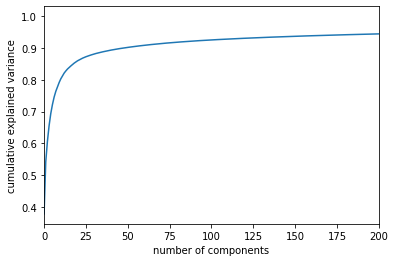

In [2]:
%%time
preprocessing_out = mlp.run_preprocessing(n_grid=100, n_samples=1_000)

# 2. Training models

In [3]:
# restore preprocessing out from files
class_weight = {1:0.01, 0:0.99}
X_train = np.loadtxt(mlp.PATH_TO_TRAIN_DATA + 'X_train.csv', delimiter=',')
X_test = np.loadtxt(mlp.PATH_TO_TRAIN_DATA + 'X_test.csv', delimiter=',')
y_train = np.loadtxt(mlp.PATH_TO_TRAIN_DATA + 'y_train.csv', delimiter=',')
y_test = np.loadtxt(mlp.PATH_TO_TRAIN_DATA + 'y_test.csv', delimiter=',')
X_val = np.loadtxt(mlp.PATH_TO_TRAIN_DATA + 'X_val.csv', delimiter=',')
y_val = np.loadtxt(mlp.PATH_TO_TRAIN_DATA + 'y_val.csv', delimiter=',')

scaler = pickle.load(open(mlp.PATH_TO_MODELS + 'scaler.pkl', 'rb'))
mini_rocket = pickle.load(
    open(mlp.PATH_TO_MODELS + 'MiniRocket_transform.pkl', 'rb')
)
pca = pickle.load(open(mlp.PATH_TO_MODELS + 'PCA.pkl', 'rb'))

## 2.1 Random forest

### 2.1.1 Grid search max_depth

In [19]:
%%time

warnings.filterwarnings('ignore')


for depth in [10, 16, 20, 24, 30, 36, 42, 48]:
    print()
    classifier = RandomForestClassifier(
        n_estimators=100, max_depth=depth, random_state=42, n_jobs=32,
        class_weight=class_weight
    )
    classifier.fit(X_train, y_train)

    y_test_proba = classifier.predict_proba(X_test)
    y_test_pred = classifier.predict(X_test)
    y_train_pred = classifier.predict(X_train)
    print(f'RandomForest classifier max_depth={depth}\n')
    df_metric = mlp.get_metric_threshold(y_test_proba, y_test)
    print('Train metrics\n')
    print(df_metric.iloc[0:2, [0, 3, 5]])

    y_val_proba = classifier.predict_proba(X_val)
    print('Validation metrics\n')
    df_metric = mlp.get_metric_threshold(y_val_proba, y_val)
    print(df_metric.iloc[0:2, [0, 3, 5]])


RandomForest classifier max_depth=10

Train metrics

              average_precision_score  F1 score count_objects
threshold=0.9                0.980588  0.055857          4459
threshold=0.8                0.980588  0.228334         20008
Validation metrics

              average_precision_score  F1 score count_objects
threshold=0.9                0.934086       0.0             0
threshold=0.8                0.934086  0.058824             3

RandomForest classifier max_depth=16

Train metrics

              average_precision_score  F1 score count_objects
threshold=0.9                0.983262  0.459702         46361
threshold=0.8                0.983262  0.597751         66297
Validation metrics

              average_precision_score  F1 score count_objects
threshold=0.9                0.949494  0.216216            12
threshold=0.8                0.949494  0.476923            31

RandomForest classifier max_depth=20

Train metrics

              average_precision_score  F1 score count_

## 2.1.2 Learning

In [4]:
%%time

classifier = RandomForestClassifier(
    n_estimators=100, max_depth=36, random_state=48, n_jobs=32,
    class_weight=class_weight
)
classifier.fit(X_train, y_train)

pickle.dump(
    classifier, open(mlp.PATH_TO_MODELS + 'RandomForest_classifier.pkl', 'wb')
)

y_test_proba = classifier.predict_proba(X_test)
y_test_pred = classifier.predict(X_test)
print('RandomForest classifier metrics')
df_metric = mlp.get_metric_threshold(y_test_proba, y_test)
df_metric.head(10)

RandomForest classifier metrics
CPU times: user 52min 33s, sys: 8.08 s, total: 52min 41s
Wall time: 2min 4s


,average_precision_score,accuracy,ROC_AUC,F1 score,precision,count_objects,recall,f-beta score (beta=0.1),f-beta score (beta=0.3),f-beta score (beta=0.5)
threshold=0.9,0.985472,0.817737,0.984658,0.777898,0.996137,99417,0.638099,0.990634,0.95203,0.89563
threshold=0.8,0.985472,0.860909,0.984658,0.839535,0.992527,113744,0.72741,0.988958,0.963531,0.925094
threshold=0.7,0.985472,0.887234,0.984658,0.874261,0.988436,123058,0.783731,0.985887,0.967569,0.939365
threshold=0.6,0.985472,0.90575,0.984658,0.8976,0.983057,130375,0.825812,0.981207,0.96784,0.946993
threshold=0.5,0.985472,0.919948,0.984658,0.914956,0.97626,136860,0.860896,0.974967,0.965577,0.950778
threshold=0.4,0.985472,0.930203,0.984658,0.927359,0.967185,142924,0.890683,0.966364,0.960374,0.950851
threshold=0.3,0.985472,0.936685,0.984658,0.935476,0.954093,149259,0.917571,0.953717,0.950968,0.946558
threshold=0.2,0.985472,0.937497,0.984658,0.937879,0.932559,156981,0.94326,0.932663,0.933433,0.93468
threshold=0.1,0.985472,0.920293,0.984658,0.92406,0.882686,170465,0.969504,0.883469,0.889261,0.898783


## 2.1.3 Validation

In [5]:
clf = pickle.load(
    open(mlp.PATH_TO_MODELS + 'RandomForest_classifier.pkl', 'rb')
)

y_pred_proba = clf.predict_proba(X_val)

print('Metrics on validattion RandomForest classifier')
df_metric = mlp.get_metric_threshold(y_pred_proba, y_val)
df_metric.head(10)

Metrics on validattion RandomForest classifier


,average_precision_score,accuracy,ROC_AUC,F1 score,precision,count_objects,recall,f-beta score (beta=0.1),f-beta score (beta=0.3),f-beta score (beta=0.5)
threshold=0.9,0.927192,0.957234,0.994131,0.696774,0.964286,56,0.545455,0.95701,0.906794,0.835913
threshold=0.8,0.927192,0.968153,0.994131,0.80226,0.910256,78,0.717172,0.907836,0.890461,0.863747
threshold=0.7,0.927192,0.979072,0.994131,0.879581,0.913043,92,0.848485,0.912356,0.907343,0.899358
threshold=0.6,0.927192,0.979982,0.994131,0.891089,0.873786,103,0.909091,0.874123,0.876597,0.880626
threshold=0.5,0.927192,0.977252,0.994131,0.883721,0.818966,116,0.959596,0.820156,0.828997,0.843694
threshold=0.4,0.927192,0.969973,0.994131,0.855895,0.753846,130,0.989899,0.75563,0.768987,0.791599
threshold=0.3,0.927192,0.957234,0.994131,0.806584,0.680556,144,0.989899,0.682668,0.698581,0.725926
threshold=0.2,0.927192,0.930846,0.994131,0.722628,0.565714,175,1.0,0.568157,0.586754,0.619524
threshold=0.1,0.927192,0.871702,0.994131,0.584071,0.4125,240,1.0,0.414913,0.43353,0.467422


## 2.2 Catboost

## 2.2.2 Learning

In [6]:
%%time

#grid search class weight
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm


columns=[
    'class_1_weight',    
    'average_precision_score',
    'accuracy',
    'ROC_AUC',
    'F1 score',
    'precision',
    'count_objects',
    'recall',
    'f-beta score (beta=0.1)',
    'f-beta score (beta=0.3)',
    'f-beta score (beta=0.5)',
]
result_search_class_weights = pd.DataFrame(columns=columns)

for x in tqdm(range(1,100), total=100):
    
    weight_1 = float(x/100)
    clf = mlp.CatBoostClassifier(
        iterations=500,
        learning_rate=0.01,
        depth=10,
        early_stopping_rounds=20,
        random_seed=42,
        class_weights={0:weight_1, 1:1.0-weight_1} 
    )
    clf.fit(
        X_train,
        y_train,
        eval_set=(X_test, y_test),
        verbose=0,
    )
    y_pred_proba = clf.predict_proba(X_val)
    df_metric = mlp.get_metric_threshold(y_pred_proba, y_val)
    result_search_class_weights.loc[len(result_search_class_weights.index)] = [weight_1] + df_metric.iloc[0,:].to_list()

result_search_class_weights.to_csv('../data/train-data/catboost_class_weight_search.csv', index=False)

 99%|█████████▉| 99/100 [2:40:27<01:37, 97.25s/it]  

CPU times: user 2d 19h 42min 43s, sys: 1h 10min, total: 2d 20h 52min 44s
Wall time: 2h 40min 30s


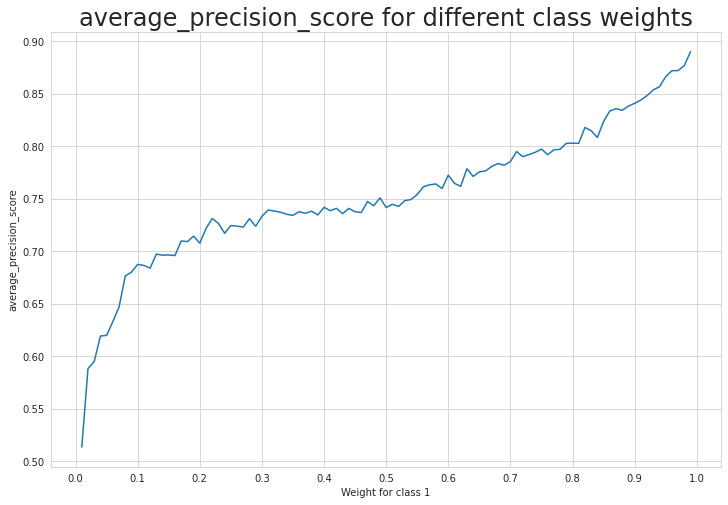

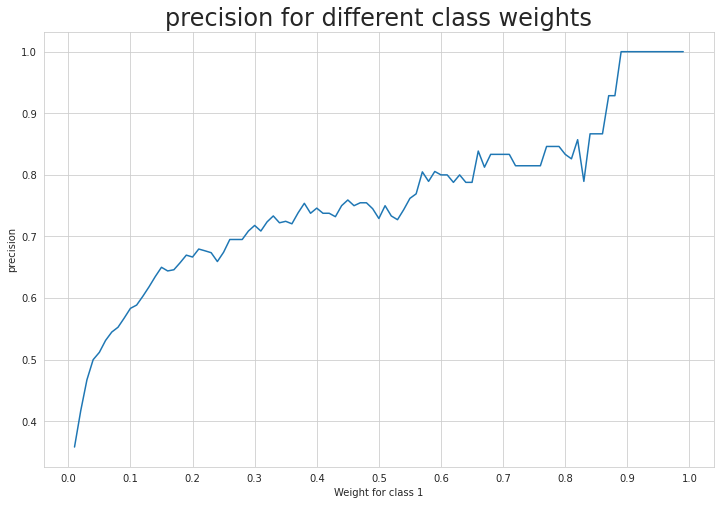

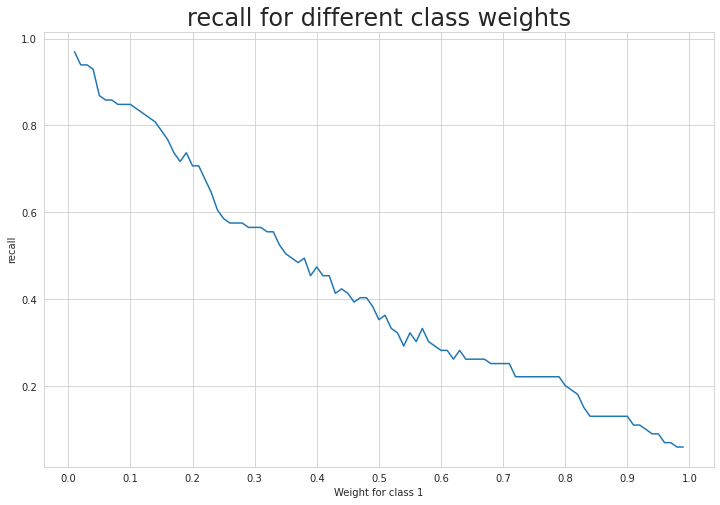

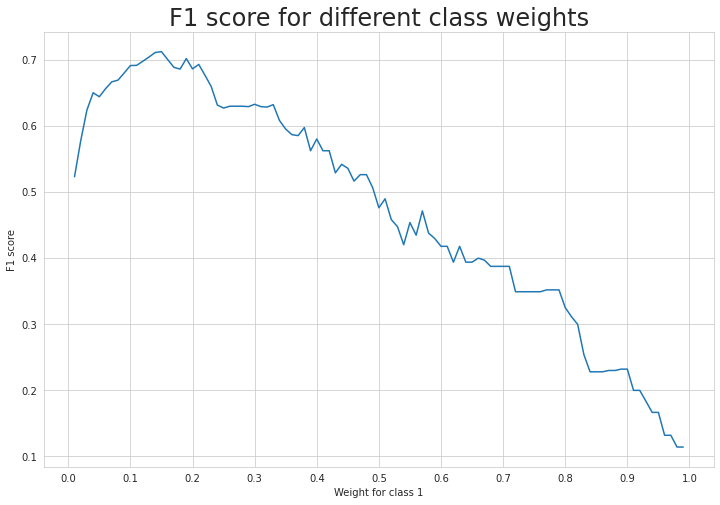

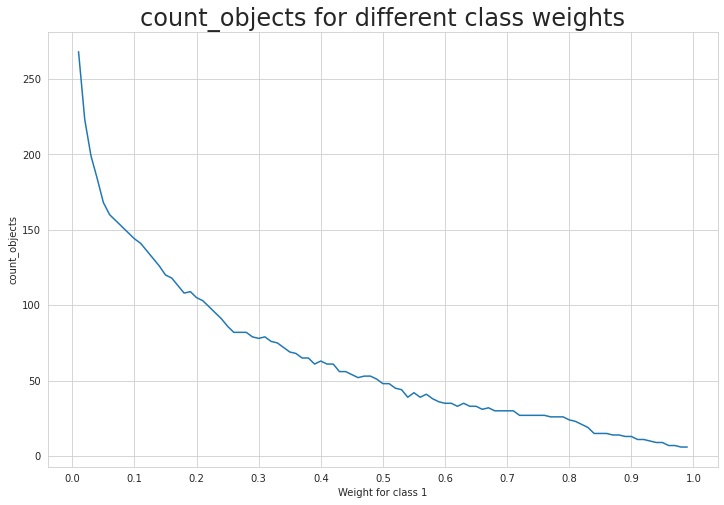

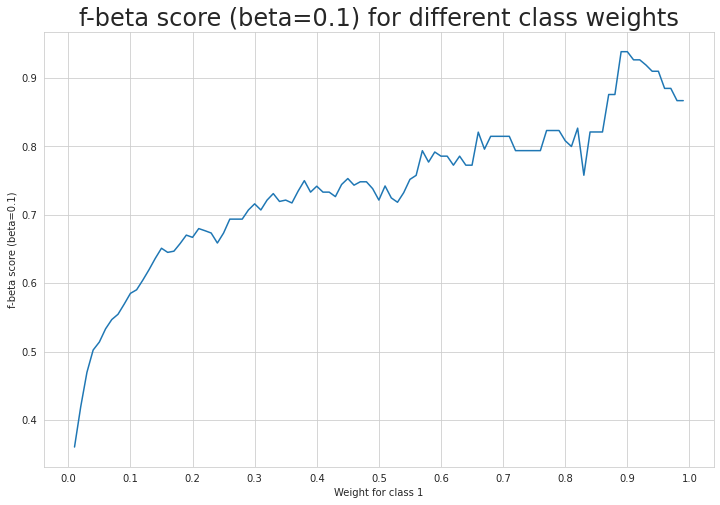

In [7]:
def plot_lineplot(df, score_name):
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    #Ploting the score for different values of weight
    sns.set_style('whitegrid')
    plt.figure(figsize=(12,8))
    sns.lineplot(data=df, x='class_1_weight', y=score_name)
    plt.xlabel('Weight for class 1')
    plt.ylabel(score_name)
    plt.xticks([round(i/10,1) for i in range(0,11,1)])
    # plt.yticks([round(i/10,1) for i in range(0,11,1)])
    plt.title(f'{score_name} for different class weights', fontsize=24)
    plt.show()

result_search_class_weights = pd.read_csv('../data/train-data/catboost_class_weight_search.csv')

plot_lineplot(df=result_search_class_weights, score_name='average_precision_score')
plot_lineplot(df=result_search_class_weights, score_name='precision')
plot_lineplot(df=result_search_class_weights, score_name='recall')
plot_lineplot(df=result_search_class_weights, score_name='F1 score')
plot_lineplot(df=result_search_class_weights, score_name='count_objects')
plot_lineplot(df=result_search_class_weights, score_name='f-beta score (beta=0.1)')

In [8]:
%%time

model = mlp.CatBoostClassifierCalibrate(
    iterations=5_000,
    learning_rate=0.01,
    depth=10,
    early_stopping_rounds=20,
    random_seed=42,
    class_weights={0:0.99, 1:0.01}
)

model.fit(
    X_train,
    y_train,
    eval_set=(X_test, y_test),
    verbose=1000,
)

pickle.dump(model, open(mlp.PATH_TO_MODELS + 'Catboost_classifier.pkl', 'wb'))

y_test_proba = model.predict_proba(X_test)
print('Catboost classifier')
df_metric = mlp.get_metric_threshold(y_test_proba, y_test)
df_metric.head(10)

0:	learn: 0.6589590	test: 0.6590209	best: 0.6590209 (0)	total: 271ms	remaining: 22m 35s
1000:	learn: 0.0147551	test: 0.0162958	best: 0.0162958 (1000)	total: 2m 57s	remaining: 11m 49s
2000:	learn: 0.0122086	test: 0.0150928	best: 0.0150928 (2000)	total: 5m 52s	remaining: 8m 48s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.0148440782
bestIteration = 2751

Shrink model to first 2752 iterations.
Catboost classifier
CPU times: user 3h 43min 17s, sys: 3min 27s, total: 3h 46min 45s
Wall time: 8min 30s


,average_precision_score,accuracy,ROC_AUC,F1 score,precision,count_objects,recall,f-beta score (beta=0.1),f-beta score (beta=0.3),f-beta score (beta=0.5)
threshold=0.9,0.993195,0.732225,0.993193,0.634599,0.999598,72175,0.464858,0.988342,0.912891,0.812638
threshold=0.8,0.993195,0.77988,0.993193,0.718092,0.999058,87067,0.56047,0.991377,0.938424,0.863858
threshold=0.7,0.993195,0.809464,0.993193,0.764991,0.998578,96356,0.619968,0.992577,0.950643,0.889888
threshold=0.6,0.993195,0.832047,0.993193,0.798565,0.998019,103499,0.665554,0.993108,0.958486,0.907368
threshold=0.5,0.993195,0.851972,0.993193,0.826716,0.99736,109851,0.705934,0.9933,0.964484,0.921294
threshold=0.4,0.993195,0.869962,0.993193,0.851053,0.996421,115681,0.7427,0.993062,0.969086,0.932696
threshold=0.3,0.993195,0.888633,0.993193,0.875287,0.994986,121868,0.781295,0.992299,0.973013,0.943382
threshold=0.2,0.993195,0.909218,0.993193,0.900846,0.992861,128873,0.824439,0.990857,0.976392,0.953888
threshold=0.1,0.993195,0.933958,0.993193,0.930169,0.987232,138239,0.879343,0.986034,0.977331,0.963587


## 2.2 Validation

In [9]:
clf = pickle.load(open(mlp.PATH_TO_MODELS + 'Catboost_classifier.pkl', 'rb'))

y_pred_proba = clf.predict_proba(X_val)

print('Metrics on validattion Catboost classifier')
df_metric = mlp.get_metric_threshold(y_pred_proba, y_val)
df_metric.head(10)

Metrics on validattion Catboost classifier


,average_precision_score,accuracy,ROC_AUC,F1 score,precision,count_objects,recall,f-beta score (beta=0.1),f-beta score (beta=0.3),f-beta score (beta=0.5)
threshold=0.9,0.923563,0.928116,0.990232,0.336134,1.0,20,0.20202,0.962363,0.754064,0.558659
threshold=0.8,0.923563,0.936306,0.990232,0.453125,1.0,29,0.292929,0.976659,0.833817,0.674419
threshold=0.7,0.923563,0.942675,0.990232,0.533333,1.0,36,0.363636,0.982968,0.873747,0.740741
threshold=0.6,0.923563,0.947225,0.990232,0.591549,0.976744,43,0.424242,0.96431,0.881911,0.774908
threshold=0.5,0.923563,0.949955,0.990232,0.630872,0.94,50,0.474747,0.930967,0.869632,0.785953
threshold=0.4,0.923563,0.953594,0.990232,0.670968,0.928571,56,0.525253,0.921565,0.873209,0.804954
threshold=0.3,0.923563,0.961783,0.990232,0.743902,0.938462,65,0.616162,0.933626,0.899608,0.849582
threshold=0.2,0.923563,0.967243,0.990232,0.790698,0.931507,73,0.686869,0.928234,0.904896,0.869565
threshold=0.1,0.923563,0.973612,0.990232,0.848168,0.880435,92,0.818182,0.879772,0.874938,0.867238


# 3. Analisys results 

In [10]:
print(f'x_val.shape = {X_val.shape}')
print(f'X_train.shape = {X_train.shape}')

x_val.shape = (1099, 82)
X_train.shape = (930814, 82)


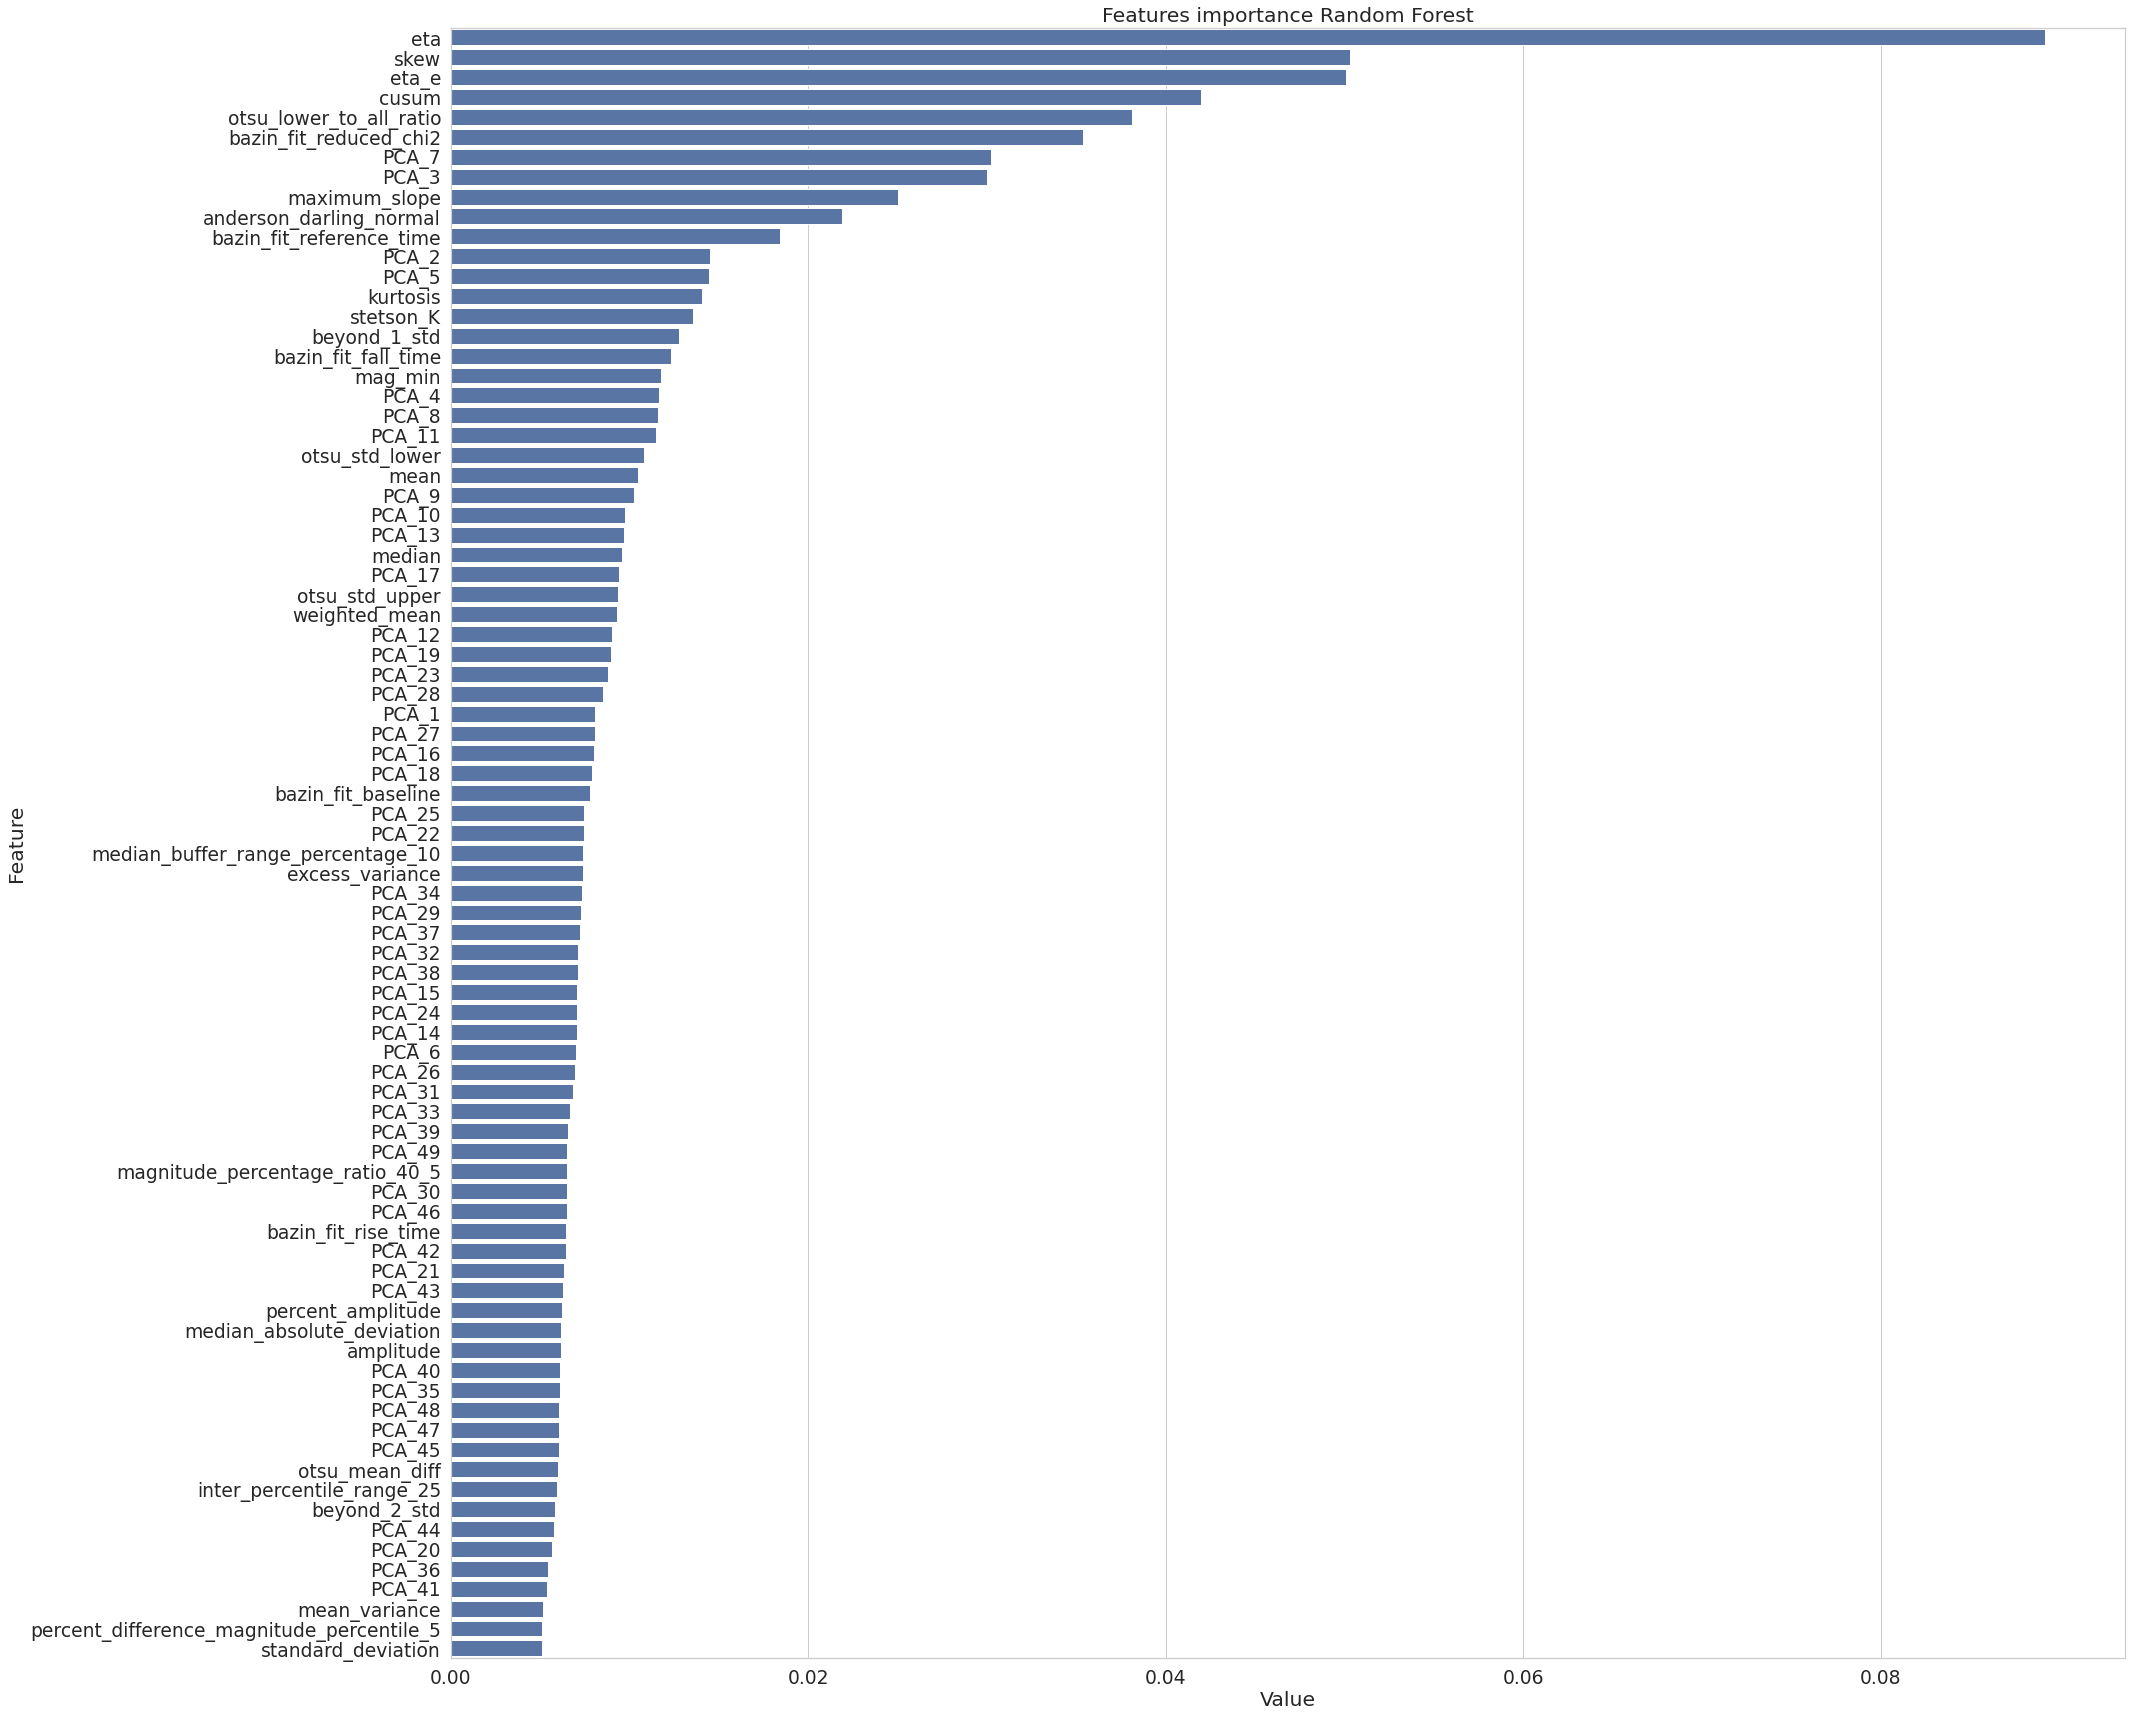

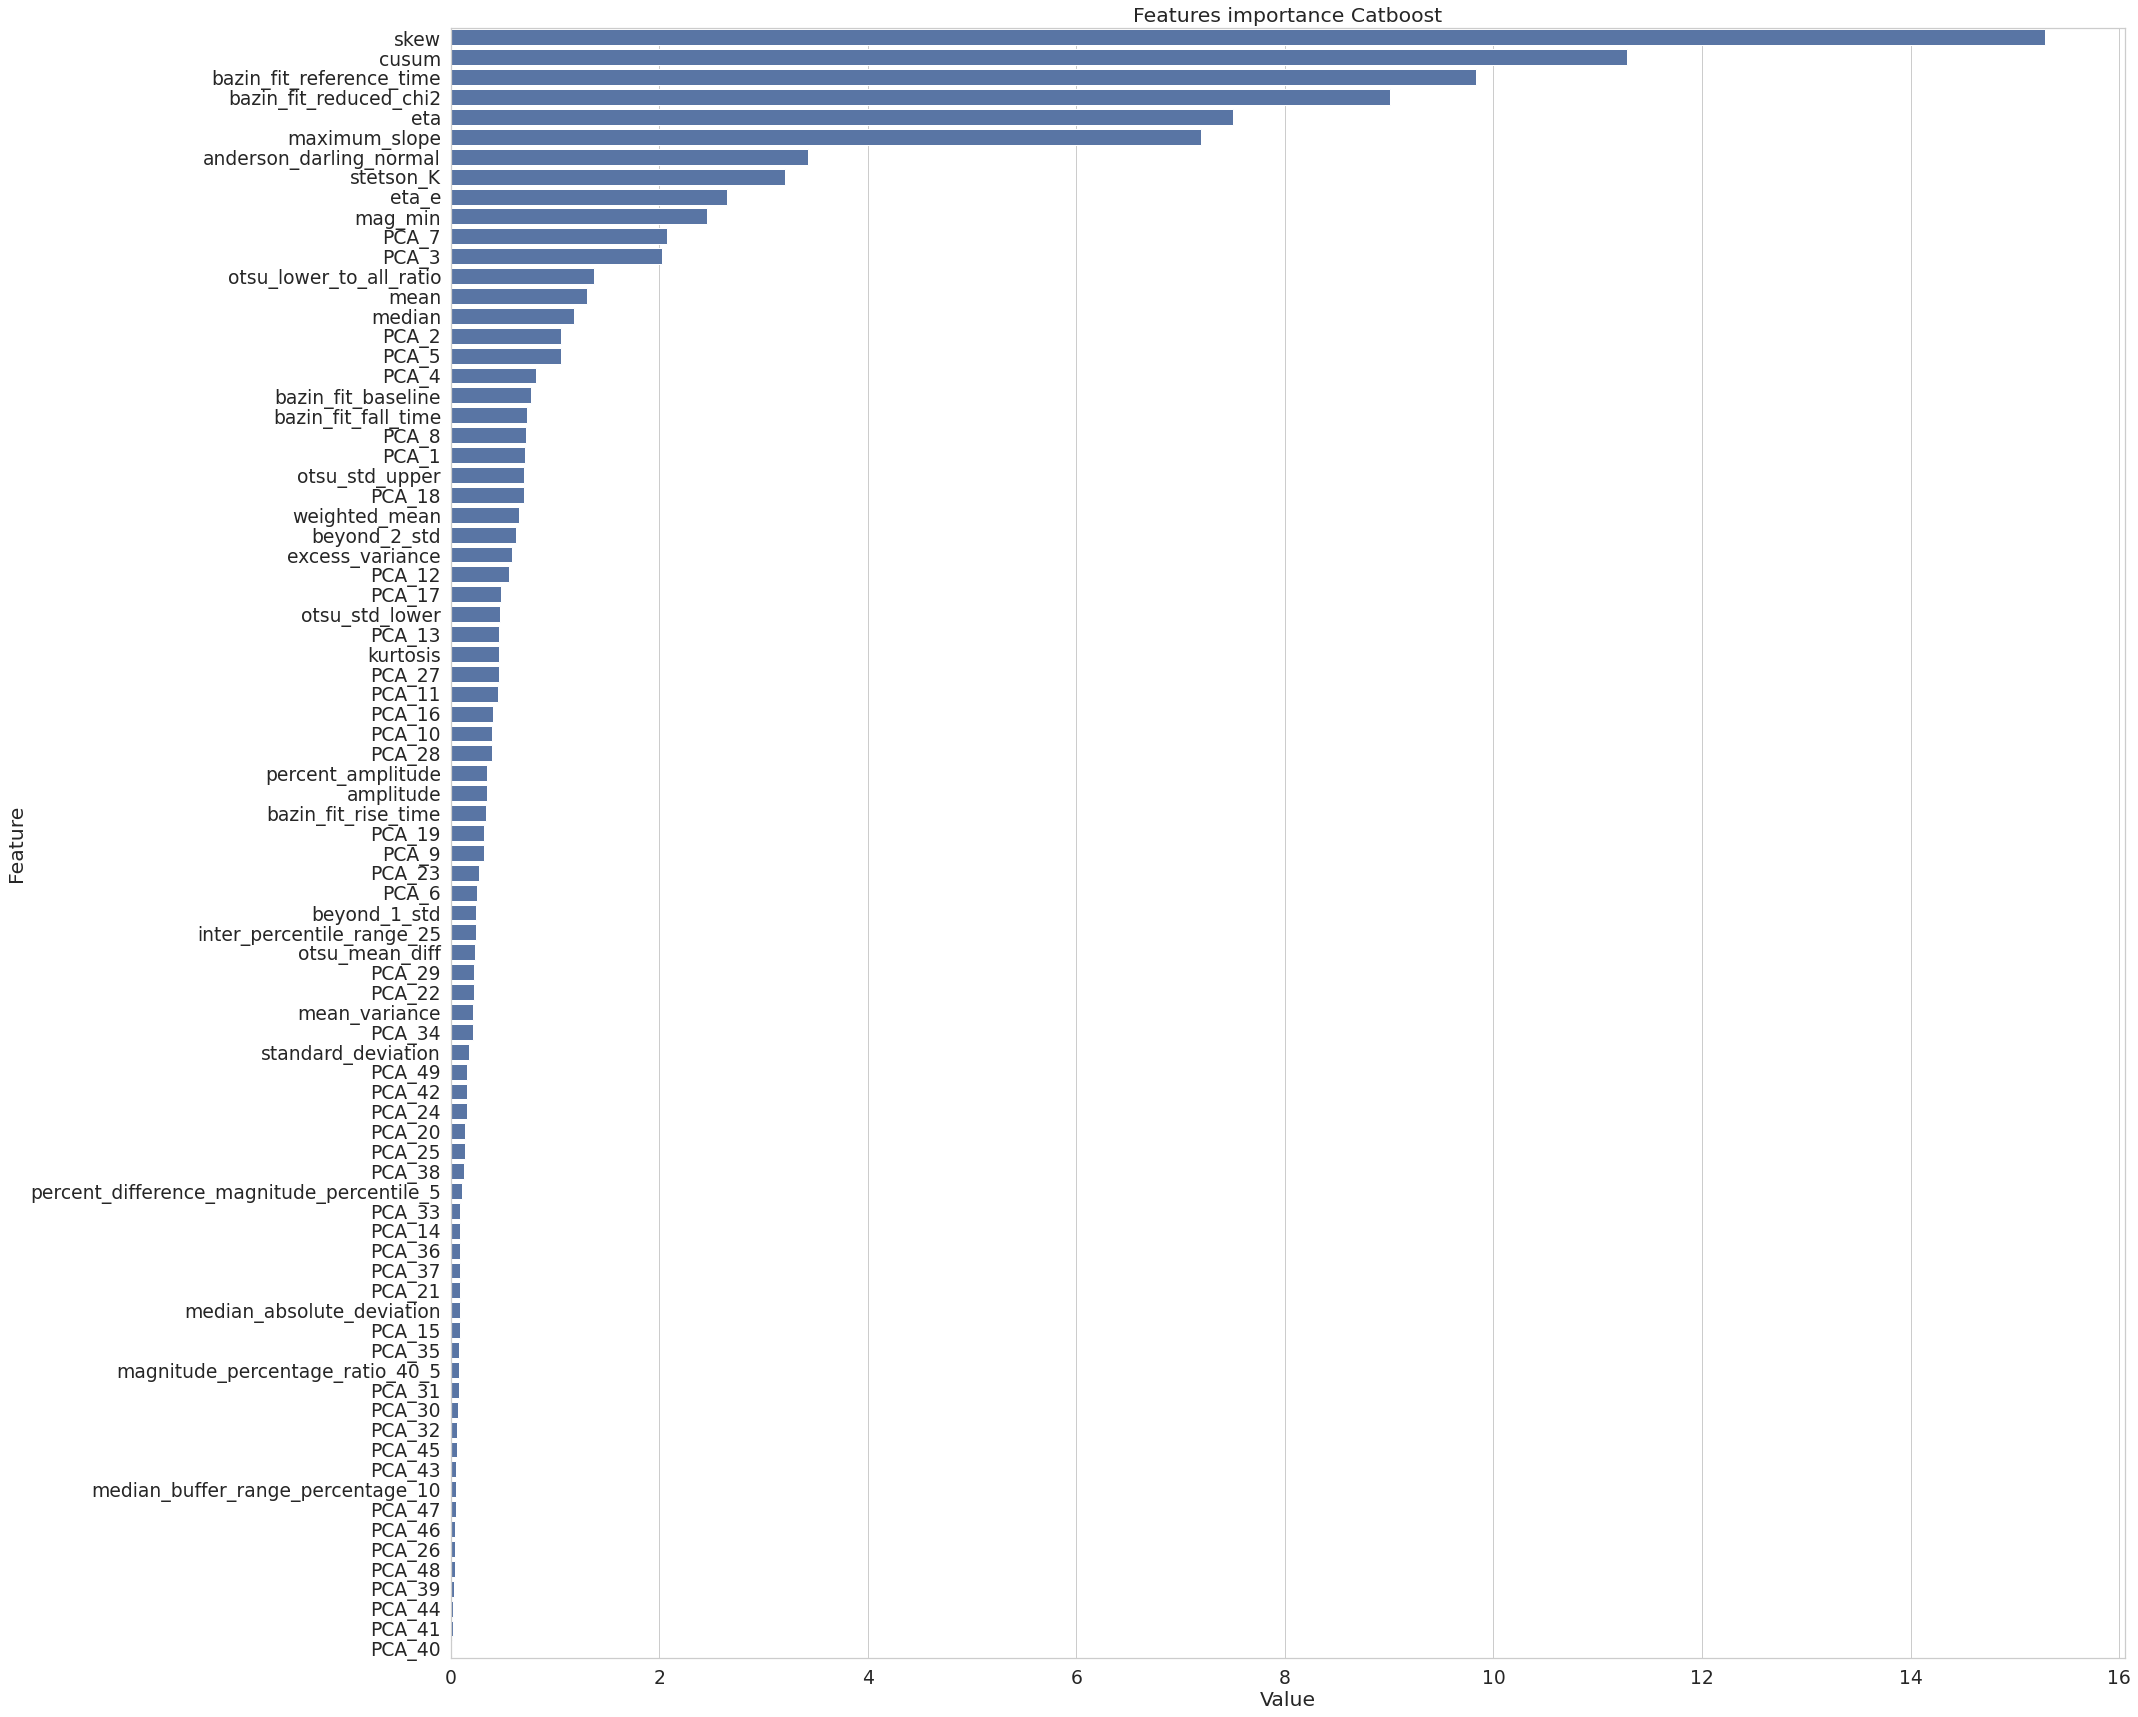

In [11]:
warnings.filterwarnings('ignore')


def plot_feature_impotance(coefficients, columns, title):
    """Plot feature impotance diagramm

    Args:
        coefficients (list): model coefficients
        columns (list): list of features
        title (str): title of plot
    """
    import matplotlib.pyplot as plt
    import seaborn as sns

    feature_imp = pd.DataFrame({'Value': coefficients, 'Feature': columns})
    feature_imp = feature_imp.sort_values(by='Value', ascending=False)
    plt.figure(figsize=(30, 30))
    sns.set(font_scale=5)
    sns.set(style='whitegrid', color_codes=True, font_scale=1.7)
    sns.barplot(x='Value', y='Feature', data=feature_imp)
    plt.title(title)
    plt.show()


features_list = pickle.load(
    open(mlp.PATH_TO_MODELS + 'features_list.pkl', 'rb')
)

rf = pickle.load(open(mlp.PATH_TO_MODELS + 'RandomForest_classifier.pkl', 'rb'))
catboost = pickle.load(
    open(mlp.PATH_TO_MODELS + 'Catboost_classifier.pkl', 'rb')
)

plot_feature_impotance(
    rf.feature_importances_, features_list, 'Features importance Random Forest'
)
plot_feature_impotance(
    catboost.feature_importances_, features_list, 'Features importance Catboost'
)

# 4. Calibration of classifiers

In [12]:
%%time

rf = pickle.load(open(mlp.PATH_TO_MODELS + 'RandomForest_classifier.pkl', 'rb'))
catboost = pickle.load(
    open(mlp.PATH_TO_MODELS + 'Catboost_classifier.pkl', 'rb')
)

rf_isotonic = CalibratedClassifierCV(rf, cv='prefit', method='isotonic')
catboost_isotonic = CalibratedClassifierCV(
    catboost, cv='prefit', method='isotonic'
)

clf_list = [
    (rf, 'RandomForest'),
    (catboost, 'Catboost'),
    (rf_isotonic, 'RandomForestIsotonic'),
    (catboost_isotonic, 'CatboostIsotonic'),
]

calibrated_models = clf_list[-2:]

for model, name in calibrated_models:
    print(f'Calibtating {model}...')
    model.fit(X_test, y_test)
    pickle.dump(
        model, open(mlp.PATH_TO_MODELS + f'calibrated_{name}.pkl', 'wb')
    )

Calibtating CalibratedClassifierCV(cv='prefit',
                       estimator=RandomForestClassifier(class_weight={0: 0.99,
                                                                      1: 0.01},
                                                        max_depth=36, n_jobs=32,
                                                        random_state=48),
                       method='isotonic')...
Calibtating CalibratedClassifierCV(cv='prefit',
                       estimator=<mlprocessing.CatBoostClassifierCalibrate object at 0x7f9fe011c4c0>,
                       method='isotonic')...
CPU times: user 19.5 s, sys: 1.16 s, total: 20.7 s
Wall time: 5.5 s


In [13]:
def plot_calibration_curve(clf_list, title):
    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec

    fig = plt.figure(figsize=(20, 20))
    gs = GridSpec(4, 3)
    colors = plt.get_cmap('Dark2')

    ax_calibration_curve = fig.add_subplot(gs[:2, :3])
    calibration_displays = {}
    for i, (clf, name) in enumerate(clf_list):
        display = CalibrationDisplay.from_estimator(
            clf,
            X_test,
            y_test,
            n_bins=10,
            name=name,
            ax=ax_calibration_curve,
            color=colors(i),
        )
        calibration_displays[name] = display

    ax_calibration_curve.grid()
    ax_calibration_curve.set_title(title)

    # Add histogram
    grid_positions = [(2, 0), (2, 1), (2, 2)]
    for i, (_, name) in enumerate(clf_list):
        row, col = grid_positions[i]
        ax = fig.add_subplot(gs[row, col])

        ax.hist(
            calibration_displays[name].y_prob,
            range=(0, 1),
            bins=10,
            label=name,
            color=colors(i),
        )
        ax.set(title=name, xlabel='Mean predicted probability', ylabel='Count')

    plt.tight_layout()
    plt.show()

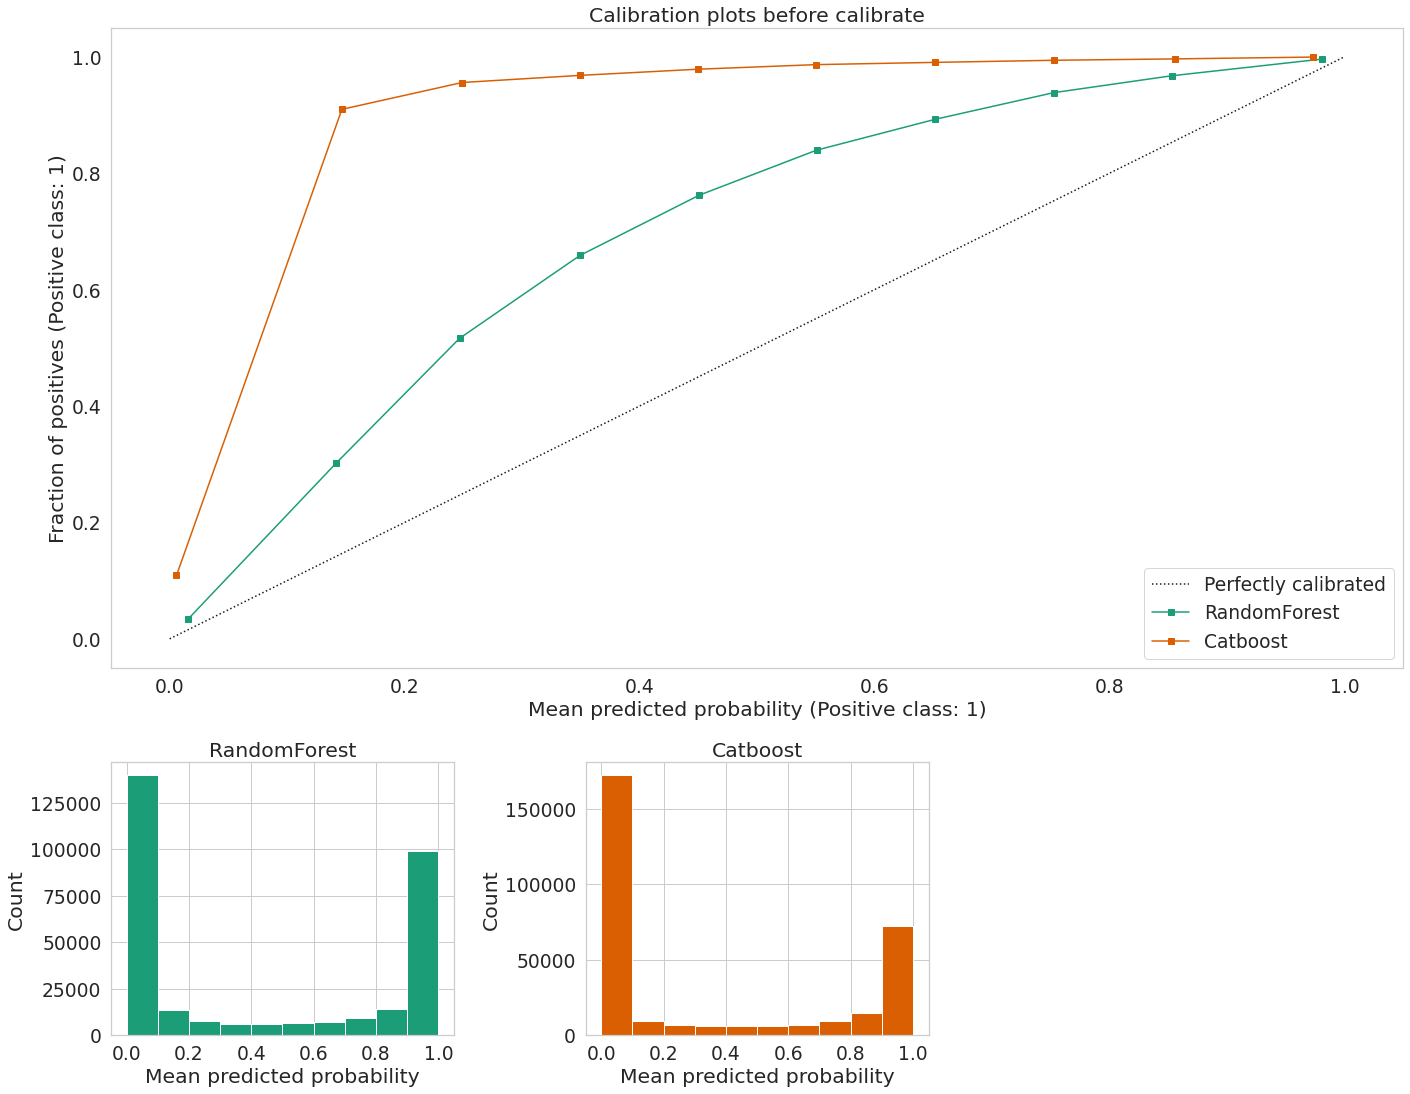

In [14]:
plot_calibration_curve(
    clf_list[:-2], title='Calibration plots before calibrate'
)

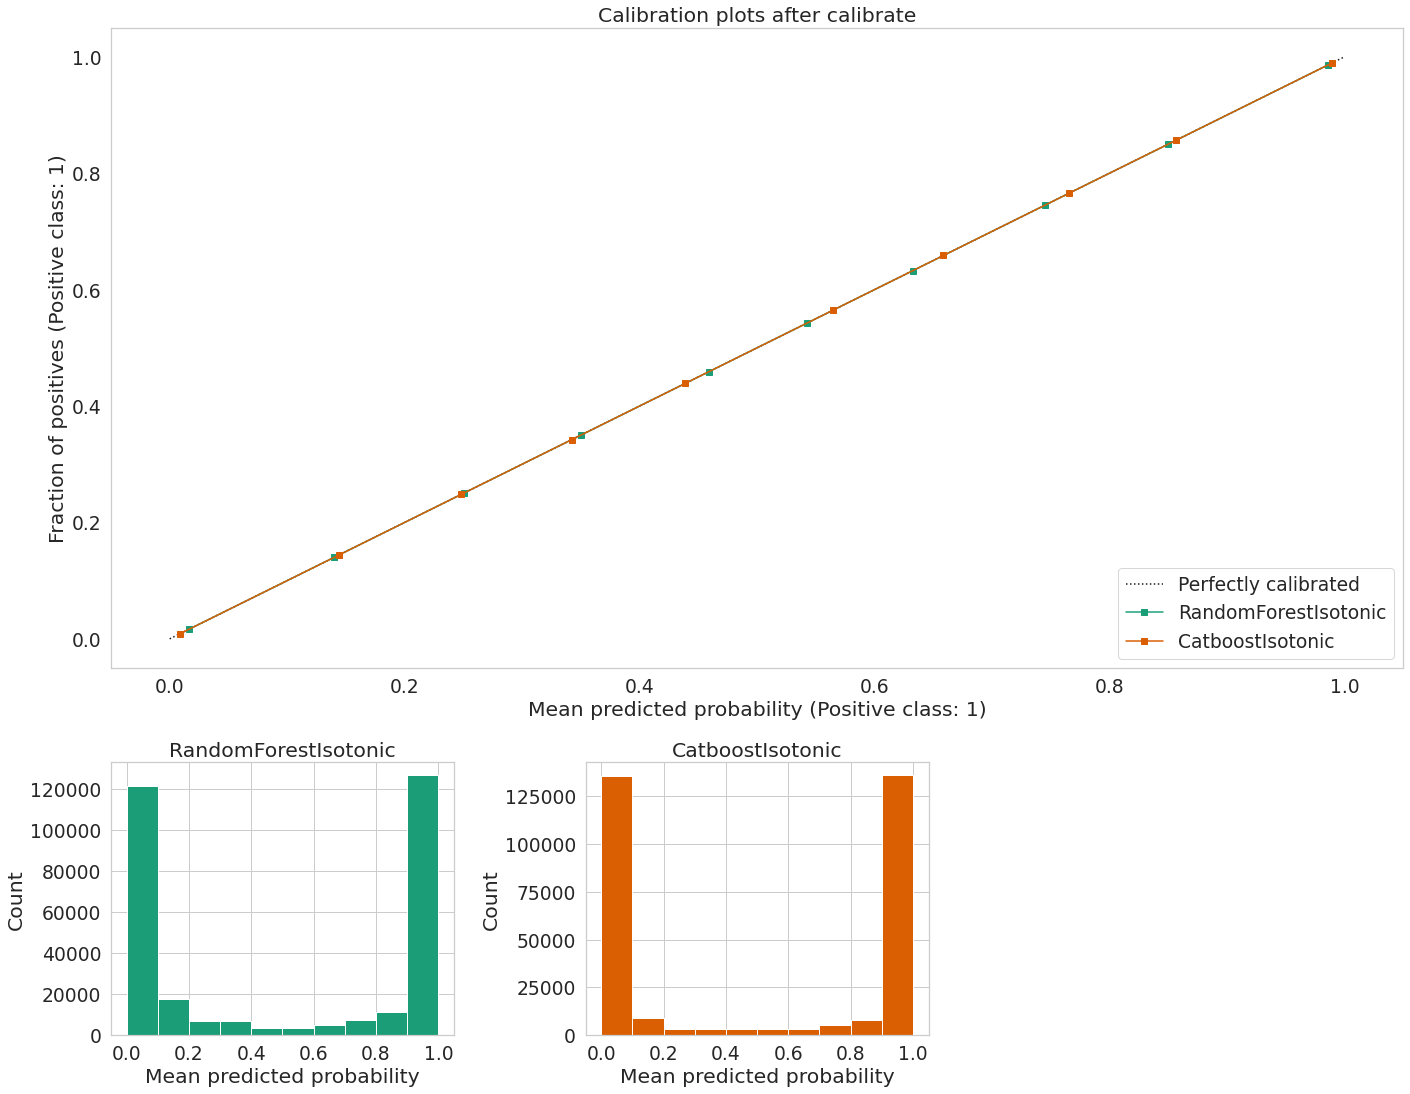

In [15]:
plot_calibration_curve(clf_list[-2:], title='Calibration plots after calibrate')